In [ ]:
import numpy as np
from PIL import Image
import os
import string
import tensorflow as tf
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Layer
from tensorflow.keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm.notebook import tqdm #to check loop progress
tqdm().pandas()

2023-04-26 08:35:01.466974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 08:35:01.650769: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


0it [00:00, ?it/s]

In [ ]:
tensorflow.__version__

'2.11.0'

In [ ]:
conda list cudnn

# packages in environment at /mnt/home/pandavis/anaconda3/envs/tf_gpu:
#
# Name                    Version                   Build  Channel
cudnn                     8.1.0.77             h90431f1_0    conda-forge
nvidia-cudnn-cu11         8.5.0.96                 pypi_0    pypi
nvidia-cudnn-cu12         8.8.1.3                  pypi_0    pypi

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pwd

'/mnt/ufs18/home-230/pandavis/CSE847MLProject/tensor/Data'

In [ ]:
#!unzip Flickr8k_Dataset.zip
#!unzip Flickr8k_text.zip

In [ ]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


# Set these path according to project folder in you system
dataset_text = ""
dataset_images = "Flicker8k_Dataset"

#we prepare our text data
filename = "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
#save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [ ]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

#2048 feature vector
#features = extract_features(dataset_images)
#dump(features, open("features.p","wb"))

In [ ]:
features=load(open("features.p","rb"))

In [ ]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename ="Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [ ]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
#dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [ ]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [ ]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2048), (47, 32), (47, 7577))

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        # attention_hidden_layer shape == (batch_size, 64, units)
        #attention_hidden_layer = (tf.nn.tanh(self.W1(features) +self.W2(hidden_with_time_axis)))
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
from keras.utils import plot_model
from keras.utils import plot_model
from keras.layers import LSTM, TimeDistributed

def define_model(vocab_size, max_length):
    # Features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 100, mask_zero=True, weights=[embedding_matrix], trainable=False, input_length=max_length)(inputs2)
    se2 = Dropout(0.5)(se1)
    lstm, hidden_state, _ = LSTM(256, return_sequences=True, return_state=True)(se2)

    # Attention layer
    attention_layer = BahdanauAttention(256)
    context_vector, _ = attention_layer(lstm, hidden_state)

    # Merging both models
    decoder1 = add([fe2, context_vector])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model


In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
#os.mkdir("models_atten_glove")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models_atten_glove/model_" + str(i) + ".h5")

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse


def extract_features(filename, model):
  try:
    image = Image.open(filename)
  except:
    print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
  image = image.resize((299,299))
  image = np.array(image)
  # for images that has 4 channels, we convert them into 3 channels
  if image.shape[2] == 4: 
      image = image[..., :3]
  image = np.expand_dims(image, axis=0)
  image = image/127.5
  image = image - 1.0
  feature = model.predict(image)
  return feature

def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None


def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'start'
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    pred = model.predict([photo,sequence], verbose=0)
    pred = np.argmax(pred)
    word = word_for_id(pred, tokenizer)
    if word is None:
        break
    in_text += ' ' + word
    if word == 'end':
        in_text += ' '
        break
  return in_text

In [ ]:
test_images = load_photos("Flickr_8k.testImages.txt")
# img_path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'

test_descriptions = {}
for img in test_images:
  img_path = "Flicker8k_Dataset/"+img
  max_length = 32

  photo = extract_features(img_path, xception_model)
  # img = Image.open(img_path)

  description = generate_desc(model, tokenizer, photo, max_length)
  test_descriptions[img] = description

1/1 [==============================] - 0s 32ms/step


In [ ]:
from keras.layers.pooling.average_pooling2d import AvgPool2D
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

scorer = rouge_scorer.RougeScorer(['rougeL'])
ref_descriptions = load_clean_descriptions("descriptions.txt", test_images)

avg_rouge_scores = {"precision":[], "recall":[], "f1measure":[]}
avg_bleu_scores = []

for img in test_descriptions:
  desc_rouge_scores = {"precision":[], "recall":[], "f1measure":[]}
  # desc_bleu_scores = []
  avg_bleu_score = sentence_bleu([i.split() for i in ref_descriptions[img]], test_descriptions[img].split())
  for desc in ref_descriptions[img]:
    rouge_score = scorer.score(test_descriptions[img], desc)
    desc_rouge_scores["precision"].append(rouge_score["rougeL"][0])
    desc_rouge_scores["recall"].append(rouge_score["rougeL"][1])
    desc_rouge_scores["f1measure"].append(rouge_score["rougeL"][2])
    # desc_bleu_scores.append(bleu_score)  
  
  # avg_bleu_score = sum(desc_bleu_scores)/len(desc_bleu_scores)
  avg_rouge_precision = sum(desc_rouge_scores["precision"])/len(desc_rouge_scores["precision"])
  avg_rouge_recall = sum(desc_rouge_scores["recall"])/len(desc_rouge_scores["recall"])
  avg_rouge_f1measure = sum(desc_rouge_scores["f1measure"])/len(desc_rouge_scores["f1measure"])

  avg_bleu_scores.append(avg_bleu_score)
  avg_rouge_scores["precision"].append(avg_rouge_precision)
  avg_rouge_scores["recall"].append(avg_rouge_recall)  
  avg_rouge_scores["f1measure"].append(avg_rouge_f1measure)    

/mnt/home/pandavis/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/mnt/home/pandavis/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/mnt/home/pandavis/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it c

In [ ]:
import json
with open("models_atten_glove/predictions.json","w") as f:
  json.dump(test_descriptions, f)

In [ ]:
print("BLEU score: ", sum(avg_bleu_scores)/len(avg_bleu_scores))
print("ROUGE precision: ", sum(avg_rouge_scores["precision"])/len(avg_rouge_scores["precision"]))
print("ROUGE recall: ", sum(avg_rouge_scores["recall"])/len(avg_rouge_scores["recall"]))
print("ROUGE f1: ", sum(avg_rouge_scores["f1measure"])/len(avg_rouge_scores["f1measure"]))

BLEU score:  0.01574151363369206
ROUGE precision:  0.3386078874925076
ROUGE recall:  0.34983939798557867
ROUGE f1:  0.332818028633087


2023-04-26 07:38:52.171812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30960 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0
2023-04-26 07:38:52.172550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30960 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3e:00.0, compute capability: 7.0
2023-04-26 07:38:55.810209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


1/1 [==============================] - 3s 3s/step



start dog is running through the grass end 


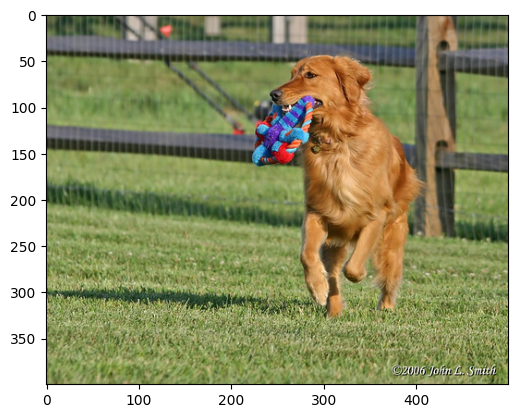

In [ ]:
img_path = 'Flicker8k_Dataset/316833109_6500b526dc.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 565ms/step



start two children are playing in the water end 


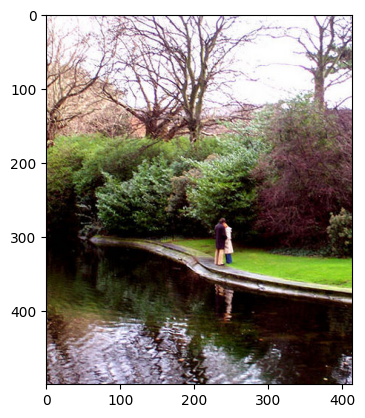

In [ ]:
img_path = 'Flicker8k_Dataset/3637013_c675de7705.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 625ms/step



start dog is running through field end 


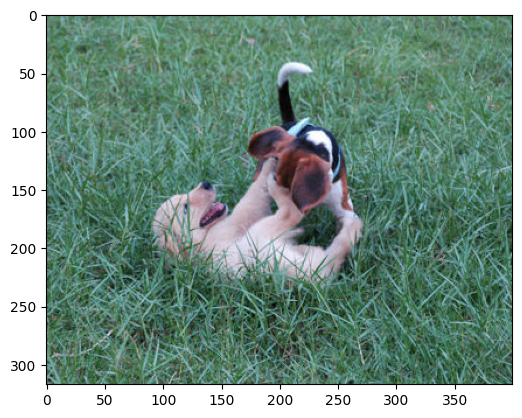

In [ ]:
img_path = 'Flicker8k_Dataset/23445819_3a458716c1.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 537ms/step



start man in black shirt and black shirt is walking down the street end 


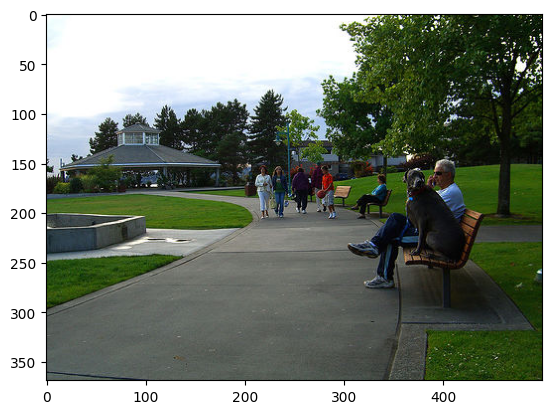

In [ ]:
img_path = 'Flicker8k_Dataset/42637987_866635edf6.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 632ms/step



start man in red shirt is standing on top of mountain end 


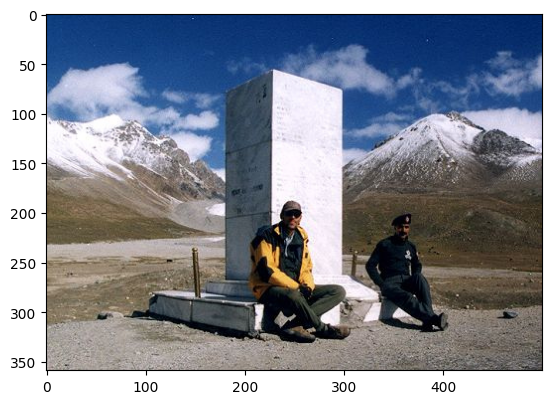

In [ ]:
img_path = 'Flicker8k_Dataset/95728664_06c43b90f1.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 539ms/step



start two dogs are running through the grass end 


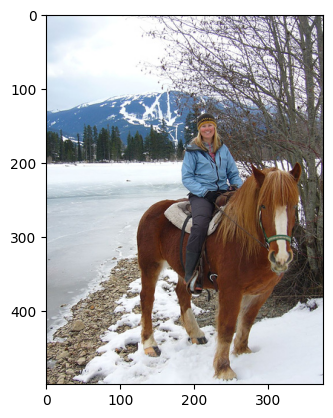

In [ ]:
img_path = 'Flicker8k_Dataset/109202756_b97fcdc62c.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 636ms/step



start man is climbing rock cliff end 


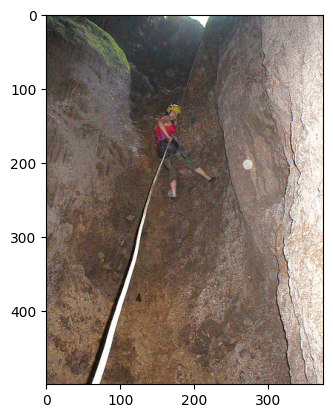

In [ ]:
img_path = 'Flicker8k_Dataset/109260216_85b0be5378.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 578ms/step



start baseball player in red shirt is running with ball end 


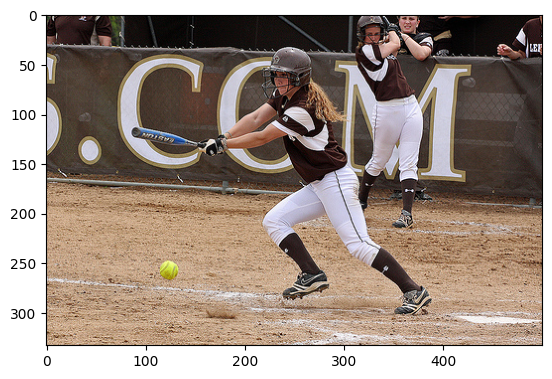

In [ ]:
img_path = 'Flicker8k_Dataset/3517124784_4b4eb62a7a.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 582ms/step



start dog is running through the grass end 


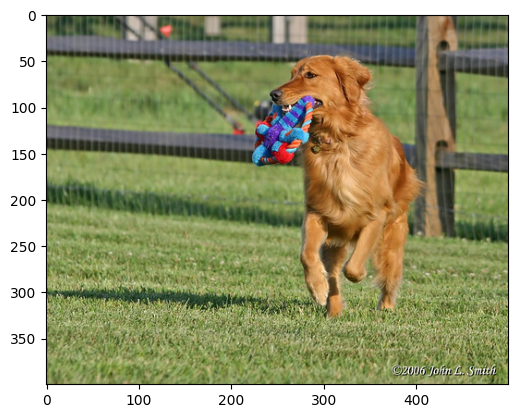

In [ ]:
img_path = 'Flicker8k_Dataset/316833109_6500b526dc.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models_atten_glove/model_9.h5',custom_objects={'BahdanauAttention': BahdanauAttention})
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)